In [106]:
import PyMieScatt as ps
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import matplotlib.pyplot as plt
from matplotlib.contour import QuadContourSet
from PyMieScatt.Mie import Mie_ab
from matplotlib.collections import LineCollection
from scipy.ndimage import zoom
from scipy.integrate import trapz
from shapely import geometry
from mpl_toolkits import mplot3d
import scipy.sparse as sps
from scipy.optimize import nnls

# Angular method using optimization tools (NNLS)

The main objective of this method is to retrieve the size of an unknown particle (in nm) knowing the wavelength of the monochromatic light and the refractive index of this particle. To do so, we need to solve the inverse problem : 
$$g = H\Delta Q$$
where $H$ is our kernel matrix (cf. next section), $g$ is a vector of scattering itensities computed with various scattering angles $\theta_i$ for the unknown particle (experimental datas) and $\Delta Q$ is the distribution (we will work with a lognormal distribution) we need to compute in order to approximate the real size of the unknown particle. 

### Particle features to retrieve
Particle size : $x^* = 340nm$

Wavelength of the light = $\lambda = 400nm$

Refractive index of the particle : $m = 1.33$ (water)

In [107]:
d = 340 #nm
wl = 400 #nm 
m = 1.33  #refractive index 

### Calculation of the kernel matrix H
We compute H using the python librairy PieMyScatt. $$H[i,j] = I(m,\lambda,x_j,\theta_i)$$
$I$ represents the scattering itensity of the monochromatic light (with a wavelength $\lambda = 400 nm$ here on a particle. The kernel matrix includes itensities calculations for several sizes $x$ where $x = [x_0 ... x_N]$, with $N=100$ here and several scattering angles $\theta$. 

For now, we choose $H \in \mathcal{M}_{N\times N}$ (ie. same resolution for $\theta$ and for $x$). 

We are working with a vector $x$ close to $x^*$. 

In [108]:
x = np.linspace(100,500,150)

In [109]:
def kernel_ang(m,wl,x,resolution):
    H = np.zeros((int(10/resolution+1),len(x)))
    for i in range(len(x)): 
        theta,SL,SR,SU = ps.ScatteringFunction(m,wl,x[i],minAngle = 0, maxAngle = 10, angleMeasure = 'degrees',angularResolution = resolution)
        H[:,i] = SL
    return H
reso = 0.1

## Measurements matrix g

The vector $g$ represents the experimental data. 

In [110]:
def lognormal(d,sigma):
    d_size = len(d)
    #print(d_size)
    d_mean = (1/d_size)*sum(d)
    q = np.zeros(d_size)
    l = -(np.log(d)+np.log(d_mean))**2/2*sigma**2
    for i in range(d_size):
        q[i] = (1/(np.sqrt(2*np.pi)*d[i]*sigma))*np.exp(-(np.log(d[i])-np.log(d_mean))**2/(2*sigma**2))
    return q

In [114]:
def measure_ang(m,wl,x,resolution):
    #B = ps.Mie_Lognormal(m,wl,sigma,dp_g,N,numberOfBins=2,returnDistribution=True)
    #print(B[7],B[8])
    #S = ps.SF_SD(m,wl,B[7],-B[8],minAngle = 0, maxAngle = 10, angleMeasure = 'degrees',angularResolution = 0.5)
    #g = S[1]
    theta,SL,SR,SU = ps.ScatteringFunction(m,wl,d,minAngle = 0, maxAngle = 10, angleMeasure = 'degrees',angularResolution = resolution)
    g = SL
    return g

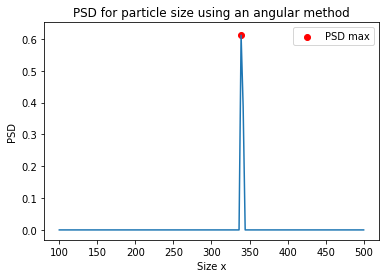

Particle size retrieved : 338.9261744966443
Real particle size : 340
Residual 5.896130415688035e-07


In [115]:
def PSD_angular(m,wl,x,resolution):
    H = kernel_ang(m,wl,x,resolution)
    g = measure_ang(m,wl,d,resolution)
    solution,res = nnls(H,g)
    max_solution = np.max(solution)
    x_max = x[int(np.argwhere(solution==max_solution))]
     
    plt.plot(x,solution)
    plt.scatter(x_max,max_solution,c = 'red',label="PSD max")
    plt.ylabel("PSD")
    plt.xlabel("Size x")
    plt.legend()
    plt.title("PSD for particle size using an angular method")
    plt.show()
    print("Particle size retrieved :",x_max)
    print("Real particle size :",d)
    print("Residual",res)

PSD_angular(m,wl,x,0.5)

### Study of the link between the discretization of theta and the residual

In [113]:
res = np.linspace(0.05,5,100)
H_d = []
g_d = []
sol_d = []
residual = []
for k in range(len(res)):
    H_d.append(kernel_ang(m,wl,x,res[k]))
    g_d.append(measure_ang(m,wl,d,res[k]))
    s,r = nnls(H_d[-1],g_d[-1])
    sol_d.append(s)
    residual.append(r)

TypeError: measure_ang() missing 1 required positional argument: 'dp_g'

In [ ]:
plt.plot(res,residual)
plt.title("Evolution of the residual depending on the discretization of $\\theta$")
plt.xlabel("Resolution of $\\theta$")
plt.ylabel("Residuals")
plt.show()

### Effect of the choice of the wavelength on the results

In [ ]:
w = np.linspace(400,800,10)
for k in range(len(w)):
    PSD_angular(m,w[k],x,0.1)

## Spectral method using optimization tools (NNLS)
We will use the same algorithms but we will discretize $H$ with another method : 
$$H[i,j]=I(m,x_j,\lambda_i,\theta)$$ with a $\theta$ constant that we will take between 10 and 20 degree.

In [ ]:
x_sp = np.linspace(100,500,100)

In [ ]:
def kernel_sp(m,x,N,theta):    #N discretization of lambda (always between 400 and 800nm)
    lamb = np.linspace(400,800,N)
    H_sp = np.zeros((len(lamb),len(x)))
    n1,n2 = np.shape(H_sp)
    for i in range(n1):
        for j in range(n2):
            S1,S2 = ps.MieS1S2(m,np.pi*x[j]/lamb[i],np.cos(theta))
            H_sp[i,j] = np.real(np.conjugate(S1)*S1)
    return H_sp

In [ ]:
def measure_sp(m,x,N,theta):
    lamb = np.linspace(400,800,N)
    g_sp = np.zeros(len(lamb))
    for k in range(len(lamb)):
        S1,S2 = ps.MieS1S2(m,np.pi*d/lamb[k],np.cos(theta))
        g_sp[k] = np.real(np.conjugate(S1)*S1)
    return g_sp

In [ ]:
def PSD_spectral(m,x,N,theta):
    H_sp = kernel_sp(m,x,N,theta)
    g_sp = measure_sp(m,x,N,theta)
    solution_sp,res_sp = nnls(H_sp,g_sp)
    max_sol_sp = np.max(solution_sp)
    x_max_sp = x[int(np.argwhere(solution_sp==max_sol_sp))]
    plt.plot(x_sp,solution_sp)
    plt.scatter(x_max_sp,max_sol_sp,c='red',label="PSD max")
    plt.ylabel("PSD")
    plt.xlabel("Size x")
    plt.legend()
    plt.title("PSD for particle size using a spectral method")
    plt.show()
    print("Particle size retrieved :",x_max_sp)
    print("Real particle size :",d)
    print("Residual",res_sp)

### Study of the link between the residuals and the discretization of $\lambda$

In [ ]:
disc = np.linspace(5,50,45)
H_spd = []
g_spd = []
sol_spd = []
residual_sp = []
theta_sp = 10
for k in range(len(disc)):
    H_spd.append(kernel_sp(m,x_sp,int(disc[k]),theta_sp))
    g_spd.append(measure_sp(m,d,int(disc[k]),theta_sp))
    s,r = nnls(H_spd[-1],g_spd[-1])
    sol_spd.append(s)
    residual_sp.append(r)

In [ ]:
print(residual_sp)
plt.plot(disc,residual_sp)
plt.title("Evolution of the residual depending on the discretization of $\\lambda$")
plt.xlabel("Resolution of $\\lambda$")
plt.ylabel("Residuals")
plt.show()